# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False, imaging_type_encoder=None):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # Handle tissue type label encoding
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_label_encoder:  # Use same flag as label encoder for consistency
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_label_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True
    )
    
    # Get the fitted encoder
    le = train_dataset.get_label_encoder()
    
    # Get the fitted imaging type encoder
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
# Analyze imaging type distribution across datasets and tissue types
print("=" * 60)
print("IMAGING TYPE ANALYSIS")
print("=" * 60)

for df_name, df in [("Train", train_df), ("Validation", valid_df), ("Test", test_df)]:
    print(f"\n{df_name} Set:")
    print(f"  Total samples: {len(df)}")
    print(f"\n  Imaging Type Distribution:")
    print(df['imaging type'].value_counts())
    print(f"\n  Imaging Type by Tissue Type:")
    print(df.groupby(['tissue type', 'imaging type']).size().unstack(fill_value=0))
    print("-" * 60)

IMAGING TYPE ANALYSIS

Train Set:
  Total samples: 1224

  Imaging Type Distribution:
imaging type
WLI    996
NBI    228
Name: count, dtype: int64

  Imaging Type by Tissue Type:
imaging type  NBI  WLI
tissue type           
HGC            45  264
LGC            97  385
NST            58  288
NTL            28   59
------------------------------------------------------------

Validation Set:
  Total samples: 304

  Imaging Type Distribution:
imaging type
WLI    250
NBI     54
Name: count, dtype: int64

  Imaging Type by Tissue Type:
imaging type  NBI  WLI
tissue type           
HGC             7   79
LGC            21   91
NST            17   67
NTL             9   13
------------------------------------------------------------

Test Set:
  Total samples: 189

  Imaging Type Distribution:
imaging type
WLI    150
NBI     39
Name: count, dtype: int64

  Imaging Type by Tissue Type:
imaging type  NBI  WLI
tissue type           
HGC            12   62
LGC            27   26
NST            

# Analyze Imaging Type Distribution

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Print encoding information
print(f"Tissue Types: {label_encoder.classes_}")

Tissue Types: ['HGC' 'LGC' 'NST' 'NTL']


# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
class RegNetWithImagingType(nn.Module):
    """Wrapper class that adds imaging type embedding to RegNet"""
    def __init__(self, base_model, num_features, num_classes=4, num_imaging_types=2, embedding_dim=16):
        super(RegNetWithImagingType, self).__init__()
        self.base_model = base_model
        
        # Replace the final fc layer with identity to get features
        self.base_model.fc = nn.Identity()
        
        # Create embedding for imaging type
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that takes image features + imaging type embedding
        self.classifier = nn.Linear(num_features + embedding_dim, num_classes)
        
    def forward(self, x, imaging_type):
        # Get image features from base model
        image_features = self.base_model(x)
        
        # Get imaging type embedding
        imaging_embedding = self.imaging_type_embedding(imaging_type)
        
        # Concatenate features
        combined_features = torch.cat([image_features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        return output

def create_regnet_y_400mf(num_classes=4, num_imaging_types=2, pretrained=True):
    """Create RegNet-Y-400MF model with imaging type support for bladder tissue classification"""
    base_model = models.regnet_y_400mf(weights='DEFAULT' if pretrained else None)
    num_features = base_model.fc.in_features
    
    # Wrap model with imaging type support
    model = RegNetWithImagingType(
        base_model,
        num_features=num_features,
        num_classes=num_classes,
        num_imaging_types=num_imaging_types
    )
    return model

def create_regnet_y_800mf(num_classes=4, num_imaging_types=2, pretrained=True):
    """Create RegNet-Y-800MF model with imaging type support for bladder tissue classification"""
    base_model = models.regnet_y_800mf(weights='DEFAULT' if pretrained else None)
    num_features = base_model.fc.in_features
    
    # Wrap model with imaging type support
    model = RegNetWithImagingType(
        base_model,
        num_features=num_features,
        num_classes=num_classes,
        num_imaging_types=num_imaging_types
    )
    return model

def create_regnet_y_1_6gf(num_classes=4, num_imaging_types=2, pretrained=True):
    """Create RegNet-Y-1.6GF model with imaging type support for bladder tissue classification"""
    base_model = models.regnet_y_1_6gf(weights='DEFAULT' if pretrained else None)
    num_features = base_model.fc.in_features
    
    # Wrap model with imaging type support
    model = RegNetWithImagingType(
        base_model,
        num_features=num_features,
        num_classes=num_classes,
        num_imaging_types=num_imaging_types
    )
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train RegNet-Y-400MF

Training RegNet-Y-400MF with Imaging Type
Downloading: "https://download.pytorch.org/models/regnet_y_400mf-e6988f5f.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-e6988f5f.pth


100%|██████████| 16.8M/16.8M [00:00<00:00, 101MB/s] 


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.67it/s, Loss=0.4418, Acc=0.8421]


Train Loss: 0.4418 Acc: 0.8421 Macro-F1: 0.7944


Val : 100%|██████████| 10/10 [00:02<00:00,  4.47it/s, Loss=0.1510, Acc=0.9441]


Val Loss: 0.1510 Acc: 0.9441 Macro-F1: 0.9247
✓ New best model saved with validation macro-F1: 0.9247

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.17it/s, Loss=0.1028, Acc=0.9696]


Train Loss: 0.1028 Acc: 0.9696 Macro-F1: 0.9576


Val : 100%|██████████| 10/10 [00:00<00:00, 10.04it/s, Loss=0.0276, Acc=0.9901]


Val Loss: 0.0276 Acc: 0.9901 Macro-F1: 0.9922
✓ New best model saved with validation macro-F1: 0.9922

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.15it/s, Loss=0.0441, Acc=0.9868]


Train Loss: 0.0441 Acc: 0.9868 Macro-F1: 0.9869


Val : 100%|██████████| 10/10 [00:00<00:00, 10.09it/s, Loss=0.0818, Acc=0.9836]


Val Loss: 0.0818 Acc: 0.9836 Macro-F1: 0.9779

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.09it/s, Loss=0.1681, Acc=0.9613]


Train Loss: 0.1681 Acc: 0.9613 Macro-F1: 0.9539


Val : 100%|██████████| 10/10 [00:00<00:00, 10.13it/s, Loss=0.1714, Acc=0.9474]


Val Loss: 0.1714 Acc: 0.9474 Macro-F1: 0.9267

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.17it/s, Loss=0.1247, Acc=0.9589]


Train Loss: 0.1247 Acc: 0.9589 Macro-F1: 0.9470


Val : 100%|██████████| 10/10 [00:01<00:00,  9.01it/s, Loss=0.0508, Acc=0.9803]


Val Loss: 0.0508 Acc: 0.9803 Macro-F1: 0.9716

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.14it/s, Loss=0.0437, Acc=0.9819]


Train Loss: 0.0437 Acc: 0.9819 Macro-F1: 0.9800


Val : 100%|██████████| 10/10 [00:00<00:00, 10.14it/s, Loss=0.0573, Acc=0.9803]


Val Loss: 0.0573 Acc: 0.9803 Macro-F1: 0.9796

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.14it/s, Loss=0.0163, Acc=0.9967]


Train Loss: 0.0163 Acc: 0.9967 Macro-F1: 0.9951


Val : 100%|██████████| 10/10 [00:01<00:00,  9.91it/s, Loss=0.0763, Acc=0.9868]


Val Loss: 0.0763 Acc: 0.9868 Macro-F1: 0.9746
Early stopping triggered after 7 epochs
Training complete in 0m 47s
Best validation macro-F1: 0.9922


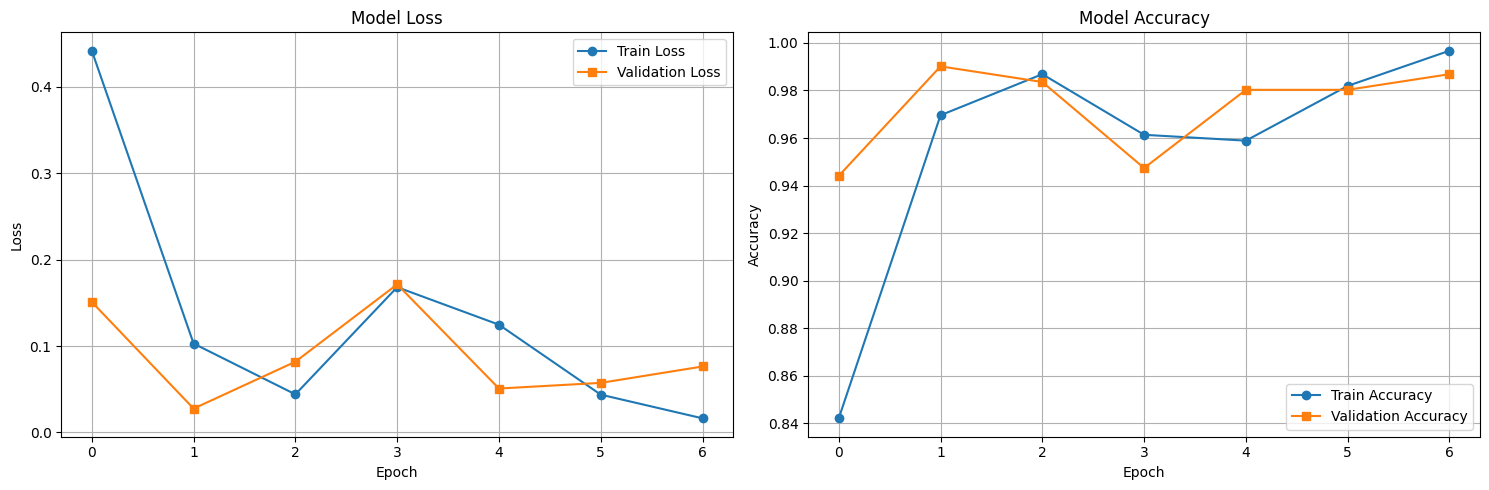

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


Test Accuracy: 44.44%
Test Loss: 1.8360

Classification Report:
              precision    recall  f1-score   support

         HGC       0.72      0.24      0.36        74
         LGC       0.46      0.25      0.32        53
         NST       0.51      0.89      0.65        37
         NTL       0.28      0.80      0.42        25

    accuracy                           0.44       189
   macro avg       0.49      0.55      0.44       189
weighted avg       0.55      0.44      0.41       189


Confusion Matrix:
[[18 14 25 17]
 [ 7 13  2 31]
 [ 0  1 33  3]
 [ 0  0  5 20]]

ROC-AUC Scores:
Macro-average AUC: 0.7731
Micro-average AUC: 0.7055
HGC AUC: 0.7945
LGC AUC: 0.6174
NST AUC: 0.9102
NTL AUC: 0.7705


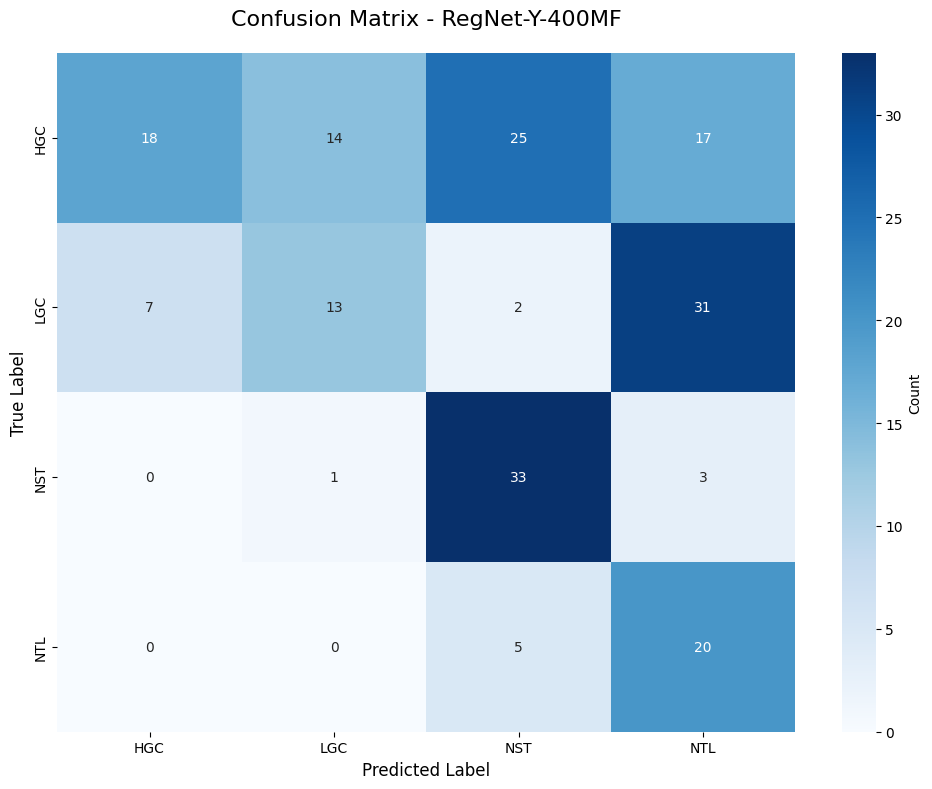

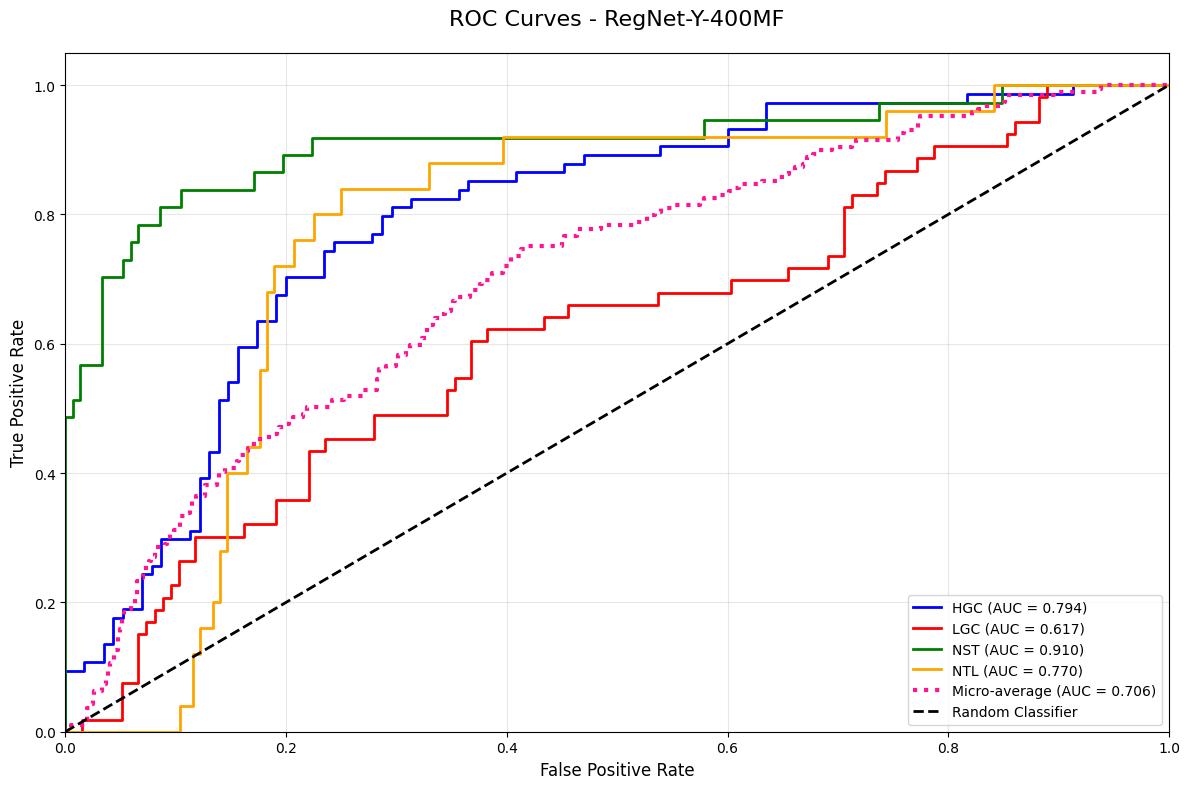


RegNet-Y-400MF training and evaluation complete!


In [16]:
print("=" * 80)
print("Training RegNet-Y-400MF with Imaging Type")
print("=" * 80)

# Create RegNet-Y-400MF model
regnet_400mf = create_regnet_y_400mf(
    num_classes=4,
    num_imaging_types=2,
    pretrained=True
)

# Create trainer
trainer_400mf = ModelTrainer(regnet_400mf, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_400mf = trainer_400mf.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="RegNet-Y-400MF_with_ImagingType")

# Plot training history
trainer_400mf.plot_training_history(save_path='regnet_y_400mf_training_history.png')

# Evaluate model
results_400mf = trainer_400mf.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_400mf['confusion_matrix'], class_names, 'RegNet-Y-400MF',
                      save_path='regnet_y_400mf_confusion_matrix.png')
# Plot ROC curves
roc_auc_400mf = plot_roc_curves(results_400mf['labels'], results_400mf['probabilities'], class_names, 'RegNet-Y-400MF',
                              save_path='regnet_y_400mf_roc_curves.png')
# Store results
results_400mf['model_name'] = 'RegNet-Y-400MF_with_ImagingType'
results_400mf['roc_auc'] = roc_auc_400mf
all_results.append(results_400mf)

print("\nRegNet-Y-400MF training and evaluation complete!")

## Train RegNet-Y-800MF

Training RegNet-Y-800MF with Imaging Type
Downloading: "https://download.pytorch.org/models/regnet_y_800mf-58fc7688.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_800mf-58fc7688.pth


100%|██████████| 24.8M/24.8M [00:00<00:00, 106MB/s] 


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.21it/s, Loss=0.4541, Acc=0.8495]


Train Loss: 0.4541 Acc: 0.8495 Macro-F1: 0.8052


Val : 100%|██████████| 10/10 [00:01<00:00,  9.54it/s, Loss=0.3773, Acc=0.9013]


Val Loss: 0.3773 Acc: 0.9013 Macro-F1: 0.9065
✓ New best model saved with validation macro-F1: 0.9065

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.15it/s, Loss=0.1790, Acc=0.9515]


Train Loss: 0.1790 Acc: 0.9515 Macro-F1: 0.9272


Val : 100%|██████████| 10/10 [00:01<00:00,  9.79it/s, Loss=1.1674, Acc=0.7270]


Val Loss: 1.1674 Acc: 0.7270 Macro-F1: 0.6939

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.24it/s, Loss=0.1394, Acc=0.9556]


Train Loss: 0.1394 Acc: 0.9556 Macro-F1: 0.9393


Val : 100%|██████████| 10/10 [00:00<00:00, 10.26it/s, Loss=0.1719, Acc=0.9474]


Val Loss: 0.1719 Acc: 0.9474 Macro-F1: 0.9221
✓ New best model saved with validation macro-F1: 0.9221

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.20it/s, Loss=0.1369, Acc=0.9548]


Train Loss: 0.1369 Acc: 0.9548 Macro-F1: 0.9407


Val : 100%|██████████| 10/10 [00:00<00:00, 10.35it/s, Loss=0.7494, Acc=0.9145]


Val Loss: 0.7494 Acc: 0.9145 Macro-F1: 0.8601

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.25it/s, Loss=0.1621, Acc=0.9531]


Train Loss: 0.1621 Acc: 0.9531 Macro-F1: 0.9387


Val : 100%|██████████| 10/10 [00:00<00:00, 10.38it/s, Loss=0.0961, Acc=0.9572]


Val Loss: 0.0961 Acc: 0.9572 Macro-F1: 0.9528
✓ New best model saved with validation macro-F1: 0.9528

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.26it/s, Loss=0.0871, Acc=0.9729]


Train Loss: 0.0871 Acc: 0.9729 Macro-F1: 0.9643


Val : 100%|██████████| 10/10 [00:00<00:00, 10.14it/s, Loss=0.4359, Acc=0.9013]


Val Loss: 0.4359 Acc: 0.9013 Macro-F1: 0.8824

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.20it/s, Loss=0.0671, Acc=0.9811]


Train Loss: 0.0671 Acc: 0.9811 Macro-F1: 0.9731


Val : 100%|██████████| 10/10 [00:01<00:00,  9.67it/s, Loss=0.0628, Acc=0.9770]


Val Loss: 0.0628 Acc: 0.9770 Macro-F1: 0.9618
✓ New best model saved with validation macro-F1: 0.9618

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.26it/s, Loss=0.0468, Acc=0.9926]


Train Loss: 0.0468 Acc: 0.9926 Macro-F1: 0.9875


Val : 100%|██████████| 10/10 [00:01<00:00,  9.50it/s, Loss=0.0237, Acc=0.9901]


Val Loss: 0.0237 Acc: 0.9901 Macro-F1: 0.9878
✓ New best model saved with validation macro-F1: 0.9878

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.28it/s, Loss=0.0121, Acc=0.9984]


Train Loss: 0.0121 Acc: 0.9984 Macro-F1: 0.9987


Val : 100%|██████████| 10/10 [00:01<00:00,  9.91it/s, Loss=0.0138, Acc=0.9934]


Val Loss: 0.0138 Acc: 0.9934 Macro-F1: 0.9948
✓ New best model saved with validation macro-F1: 0.9948

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.21it/s, Loss=0.0123, Acc=0.9967]


Train Loss: 0.0123 Acc: 0.9967 Macro-F1: 0.9940


Val : 100%|██████████| 10/10 [00:00<00:00, 10.20it/s, Loss=0.0100, Acc=0.9967]


Val Loss: 0.0100 Acc: 0.9967 Macro-F1: 0.9974
✓ New best model saved with validation macro-F1: 0.9974

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.24it/s, Loss=0.0066, Acc=0.9992]


Train Loss: 0.0066 Acc: 0.9992 Macro-F1: 0.9983


Val : 100%|██████████| 10/10 [00:01<00:00,  9.99it/s, Loss=0.0107, Acc=0.9967]


Val Loss: 0.0107 Acc: 0.9967 Macro-F1: 0.9974

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.15it/s, Loss=0.0058, Acc=0.9992]


Train Loss: 0.0058 Acc: 0.9992 Macro-F1: 0.9993


Val : 100%|██████████| 10/10 [00:01<00:00,  9.71it/s, Loss=0.0068, Acc=0.9967]


Val Loss: 0.0068 Acc: 0.9967 Macro-F1: 0.9974

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.21it/s, Loss=0.0031, Acc=1.0000]


Train Loss: 0.0031 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:00<00:00, 10.23it/s, Loss=0.0074, Acc=1.0000]


Val Loss: 0.0074 Acc: 1.0000 Macro-F1: 1.0000
✓ New best model saved with validation macro-F1: 1.0000

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.27it/s, Loss=0.0031, Acc=1.0000]


Train Loss: 0.0031 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:00<00:00, 10.18it/s, Loss=0.0064, Acc=1.0000]


Val Loss: 0.0064 Acc: 1.0000 Macro-F1: 1.0000

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.18it/s, Loss=0.0041, Acc=0.9992]


Train Loss: 0.0041 Acc: 0.9992 Macro-F1: 0.9993


Val : 100%|██████████| 10/10 [00:00<00:00, 10.08it/s, Loss=0.0083, Acc=0.9967]


Val Loss: 0.0083 Acc: 0.9967 Macro-F1: 0.9974

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.22it/s, Loss=0.0045, Acc=0.9992]


Train Loss: 0.0045 Acc: 0.9992 Macro-F1: 0.9994


Val : 100%|██████████| 10/10 [00:01<00:00,  9.87it/s, Loss=0.0082, Acc=0.9967]


Val Loss: 0.0082 Acc: 0.9967 Macro-F1: 0.9974

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.21it/s, Loss=0.0027, Acc=1.0000]


Train Loss: 0.0027 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.96it/s, Loss=0.0065, Acc=1.0000]


Val Loss: 0.0065 Acc: 1.0000 Macro-F1: 1.0000

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.16it/s, Loss=0.0044, Acc=0.9992]


Train Loss: 0.0044 Acc: 0.9992 Macro-F1: 0.9993


Val : 100%|██████████| 10/10 [00:00<00:00, 10.06it/s, Loss=0.0058, Acc=1.0000]


Val Loss: 0.0058 Acc: 1.0000 Macro-F1: 1.0000
Early stopping triggered after 18 epochs
Training complete in 1m 54s
Best validation macro-F1: 1.0000


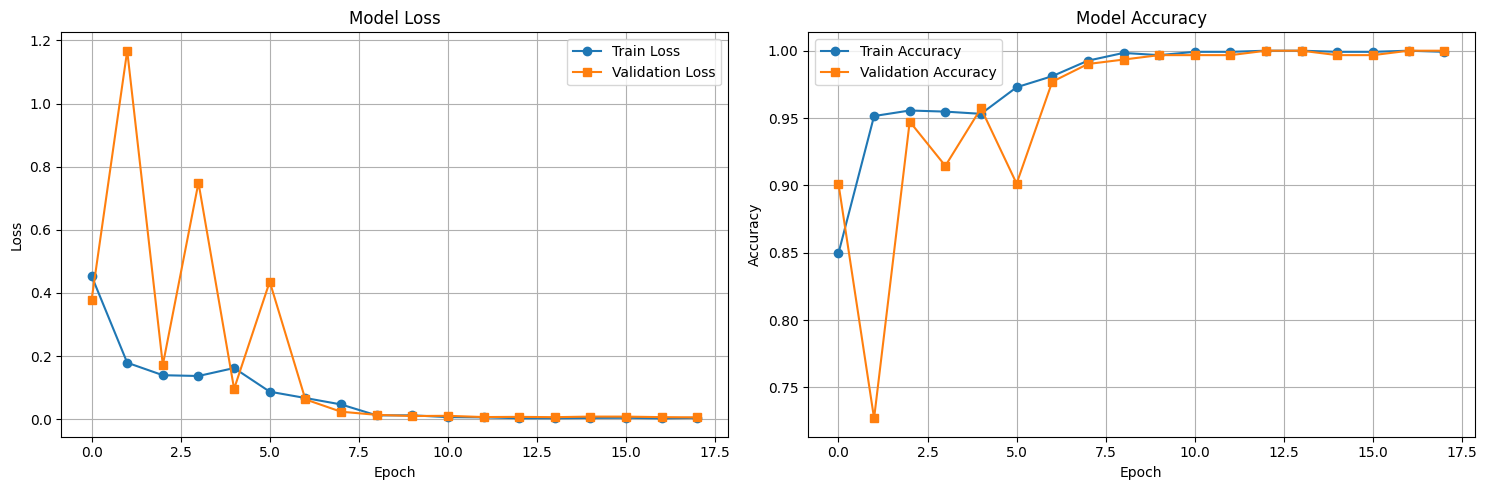

Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  7.95it/s]


Test Accuracy: 30.16%
Test Loss: 2.4973

Classification Report:
              precision    recall  f1-score   support

         HGC       0.30      0.18      0.22        74
         LGC       0.02      0.02      0.02        53
         NST       0.61      0.76      0.67        37
         NTL       0.33      0.60      0.43        25

    accuracy                           0.30       189
   macro avg       0.31      0.39      0.34       189
weighted avg       0.28      0.30      0.28       189


Confusion Matrix:
[[13 53  5  3]
 [26  1  4 22]
 [ 4  0 28  5]
 [ 1  0  9 15]]

ROC-AUC Scores:
Macro-average AUC: 0.6403
Micro-average AUC: 0.6469
HGC AUC: 0.5106
LGC AUC: 0.4061
NST AUC: 0.8922
NTL AUC: 0.7522


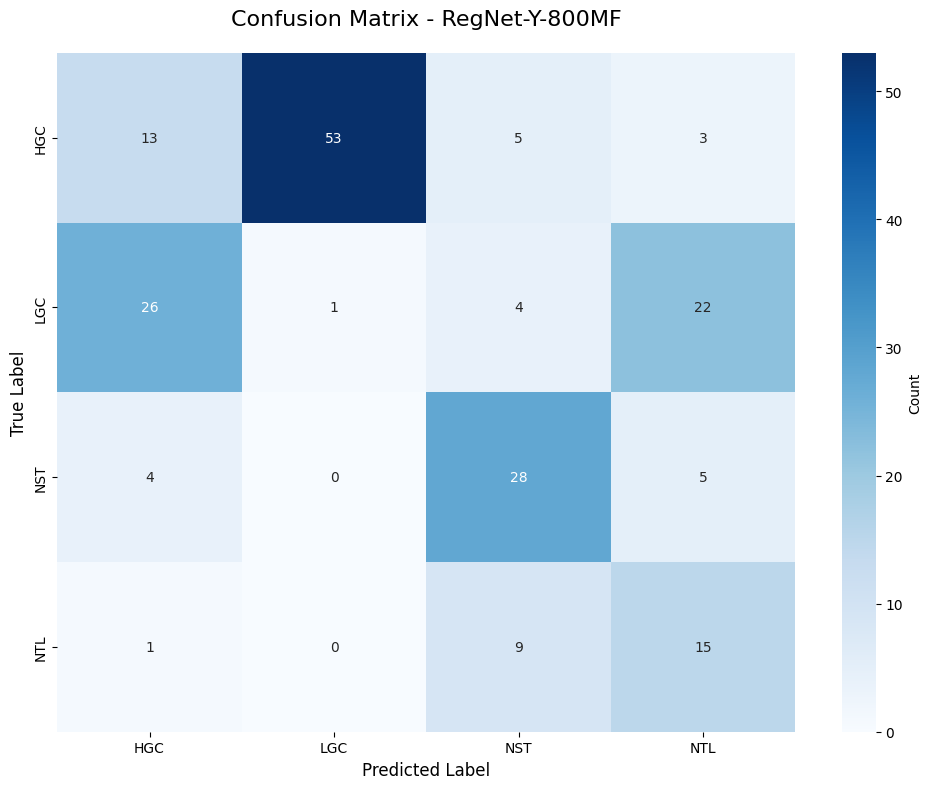

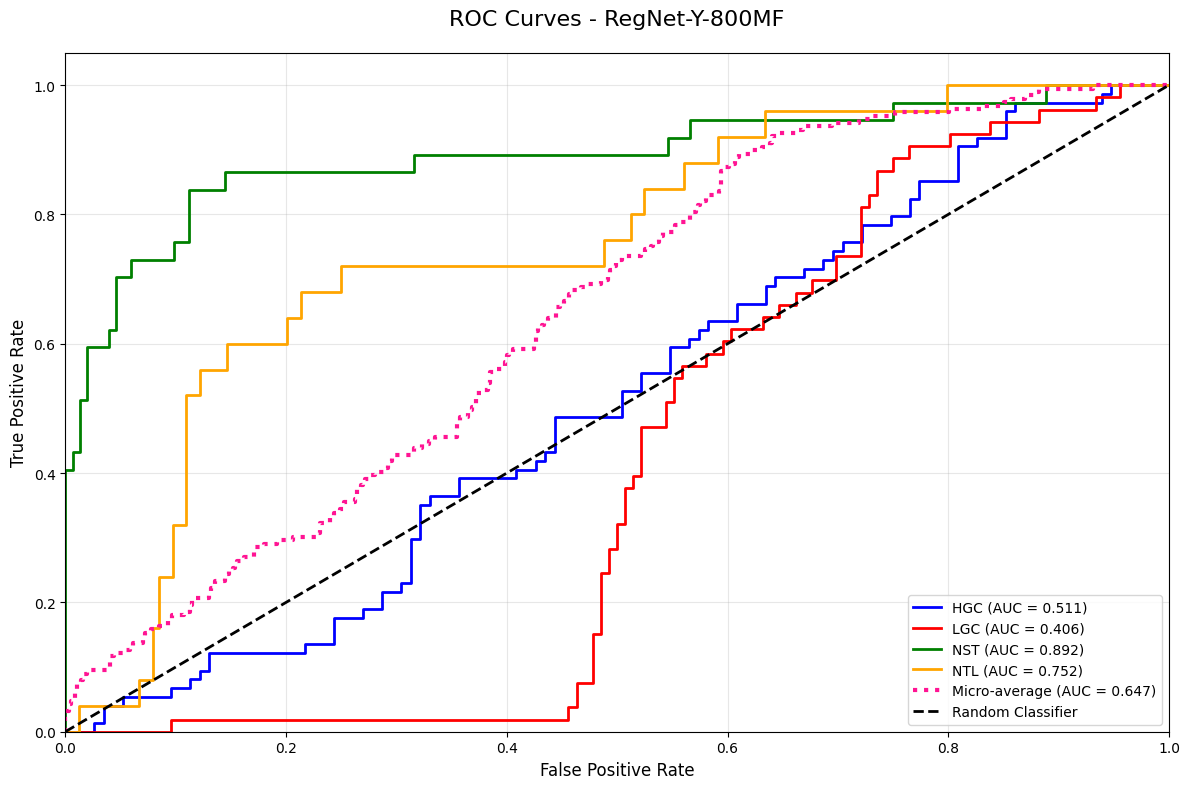


RegNet-Y-800MF training and evaluation complete!


In [17]:
print("=" * 80)
print("Training RegNet-Y-800MF with Imaging Type")
print("=" * 80)

# Create RegNet-Y-800MF model
regnet_800mf = create_regnet_y_800mf(
    num_classes=4,
    num_imaging_types=2,
    pretrained=True
)

# Create trainer
trainer_800mf = ModelTrainer(regnet_800mf, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_800mf = trainer_800mf.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="RegNet-Y-800MF_with_ImagingType")

# Plot training history
trainer_800mf.plot_training_history(save_path='regnet_y_800mf_training_history.png')

# Evaluate model
results_800mf = trainer_800mf.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_800mf['confusion_matrix'], class_names, 'RegNet-Y-800MF',
                      save_path='regnet_y_800mf_confusion_matrix.png')
# Plot ROC curves
roc_auc_800mf = plot_roc_curves(results_800mf['labels'], results_800mf['probabilities'], class_names, 'RegNet-Y-800MF',
                              save_path='regnet_y_800mf_roc_curves.png')
# Store results
results_800mf['model_name'] = 'RegNet-Y-800MF_with_ImagingType'
results_800mf['roc_auc'] = roc_auc_800mf
all_results.append(results_800mf)

print("\nRegNet-Y-800MF training and evaluation complete!")

## Train RegNet-Y-1.6GF

Training RegNet-Y-1.6GF with Imaging Type
Downloading: "https://download.pytorch.org/models/regnet_y_1_6gf-0d7bc02a.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_1_6gf-0d7bc02a.pth


100%|██████████| 43.2M/43.2M [00:00<00:00, 108MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.76it/s, Loss=0.4676, Acc=0.8479]


Train Loss: 0.4676 Acc: 0.8479 Macro-F1: 0.8039


Val : 100%|██████████| 10/10 [00:01<00:00,  8.54it/s, Loss=0.1299, Acc=0.9638]


Val Loss: 0.1299 Acc: 0.9638 Macro-F1: 0.9670
✓ New best model saved with validation macro-F1: 0.9670

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.82it/s, Loss=0.1515, Acc=0.9515]


Train Loss: 0.1515 Acc: 0.9515 Macro-F1: 0.9333


Val : 100%|██████████| 10/10 [00:01<00:00,  9.49it/s, Loss=0.5585, Acc=0.7599]


Val Loss: 0.5585 Acc: 0.7599 Macro-F1: 0.7264

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.74it/s, Loss=0.1860, Acc=0.9465]


Train Loss: 0.1860 Acc: 0.9465 Macro-F1: 0.9241


Val : 100%|██████████| 10/10 [00:01<00:00,  9.40it/s, Loss=0.1615, Acc=0.9572]


Val Loss: 0.1615 Acc: 0.9572 Macro-F1: 0.9381

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.81it/s, Loss=0.1655, Acc=0.9630]


Train Loss: 0.1655 Acc: 0.9630 Macro-F1: 0.9407


Val : 100%|██████████| 10/10 [00:01<00:00,  9.63it/s, Loss=0.0819, Acc=0.9704]


Val Loss: 0.0819 Acc: 0.9704 Macro-F1: 0.9640

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.80it/s, Loss=0.0618, Acc=0.9794]


Train Loss: 0.0618 Acc: 0.9794 Macro-F1: 0.9744


Val : 100%|██████████| 10/10 [00:01<00:00,  9.34it/s, Loss=0.1093, Acc=0.9605]


Val Loss: 0.1093 Acc: 0.9605 Macro-F1: 0.9644

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.80it/s, Loss=0.0636, Acc=0.9770]


Train Loss: 0.0636 Acc: 0.9770 Macro-F1: 0.9736


Val : 100%|██████████| 10/10 [00:01<00:00,  9.32it/s, Loss=0.0573, Acc=0.9836]


Val Loss: 0.0573 Acc: 0.9836 Macro-F1: 0.9871
✓ New best model saved with validation macro-F1: 0.9871

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.82it/s, Loss=0.0635, Acc=0.9803]


Train Loss: 0.0635 Acc: 0.9803 Macro-F1: 0.9726


Val : 100%|██████████| 10/10 [00:01<00:00,  9.80it/s, Loss=0.0721, Acc=0.9704]


Val Loss: 0.0721 Acc: 0.9704 Macro-F1: 0.9767

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.82it/s, Loss=0.0455, Acc=0.9893]


Train Loss: 0.0455 Acc: 0.9893 Macro-F1: 0.9868


Val : 100%|██████████| 10/10 [00:01<00:00,  9.63it/s, Loss=0.0085, Acc=1.0000]


Val Loss: 0.0085 Acc: 1.0000 Macro-F1: 1.0000
✓ New best model saved with validation macro-F1: 1.0000

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.80it/s, Loss=0.0080, Acc=0.9992]


Train Loss: 0.0080 Acc: 0.9992 Macro-F1: 0.9994


Val : 100%|██████████| 10/10 [00:01<00:00,  9.61it/s, Loss=0.0063, Acc=1.0000]


Val Loss: 0.0063 Acc: 1.0000 Macro-F1: 1.0000

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.83it/s, Loss=0.0096, Acc=0.9975]


Train Loss: 0.0096 Acc: 0.9975 Macro-F1: 0.9981


Val : 100%|██████████| 10/10 [00:01<00:00,  9.65it/s, Loss=0.0051, Acc=1.0000]


Val Loss: 0.0051 Acc: 1.0000 Macro-F1: 1.0000

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.83it/s, Loss=0.0043, Acc=0.9992]


Train Loss: 0.0043 Acc: 0.9992 Macro-F1: 0.9993


Val : 100%|██████████| 10/10 [00:01<00:00,  9.21it/s, Loss=0.0039, Acc=1.0000]


Val Loss: 0.0039 Acc: 1.0000 Macro-F1: 1.0000

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.81it/s, Loss=0.0072, Acc=0.9984]


Train Loss: 0.0072 Acc: 0.9984 Macro-F1: 0.9987


Val : 100%|██████████| 10/10 [00:01<00:00,  9.80it/s, Loss=0.0036, Acc=1.0000]


Val Loss: 0.0036 Acc: 1.0000 Macro-F1: 1.0000

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.80it/s, Loss=0.0039, Acc=1.0000]


Train Loss: 0.0039 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.59it/s, Loss=0.0034, Acc=1.0000]


Val Loss: 0.0034 Acc: 1.0000 Macro-F1: 1.0000
Early stopping triggered after 13 epochs
Training complete in 1m 57s
Best validation macro-F1: 1.0000


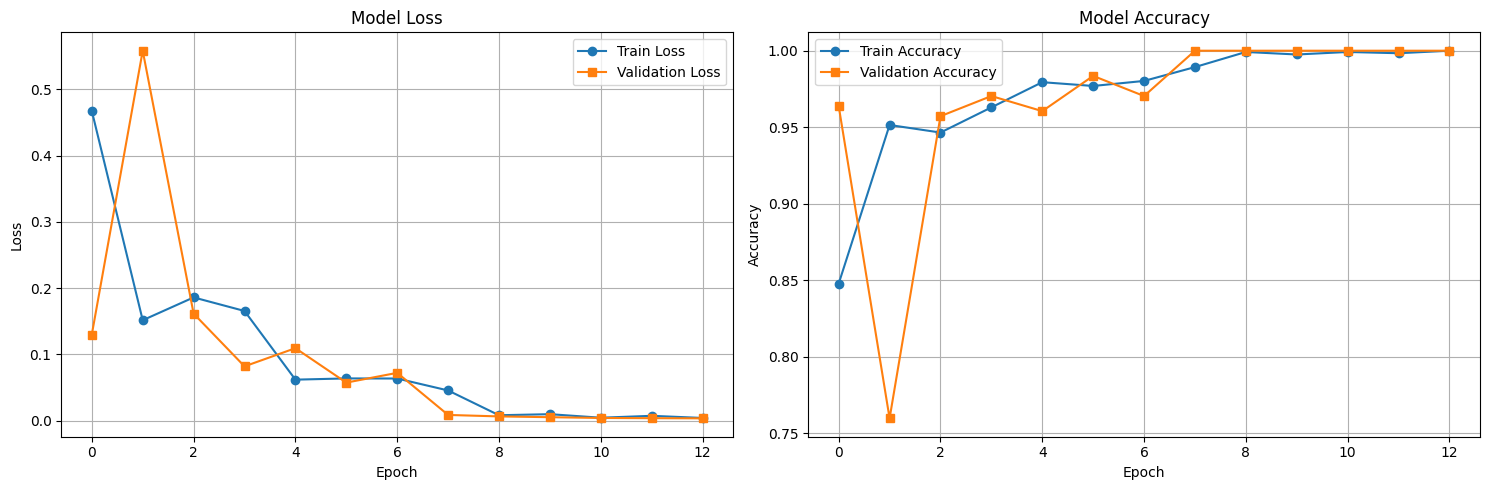

Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  7.57it/s]


Test Accuracy: 46.03%
Test Loss: 2.1932

Classification Report:
              precision    recall  f1-score   support

         HGC       0.67      0.51      0.58        74
         LGC       0.17      0.13      0.15        53
         NST       0.58      0.70      0.63        37
         NTL       0.35      0.64      0.45        25

    accuracy                           0.46       189
   macro avg       0.44      0.50      0.45       189
weighted avg       0.47      0.46      0.45       189


Confusion Matrix:
[[38 33  1  2]
 [15  7  9 22]
 [ 4  1 26  6]
 [ 0  0  9 16]]

ROC-AUC Scores:
Macro-average AUC: 0.7124
Micro-average AUC: 0.6944
HGC AUC: 0.6719
LGC AUC: 0.4832
NST AUC: 0.8979
NTL AUC: 0.7966


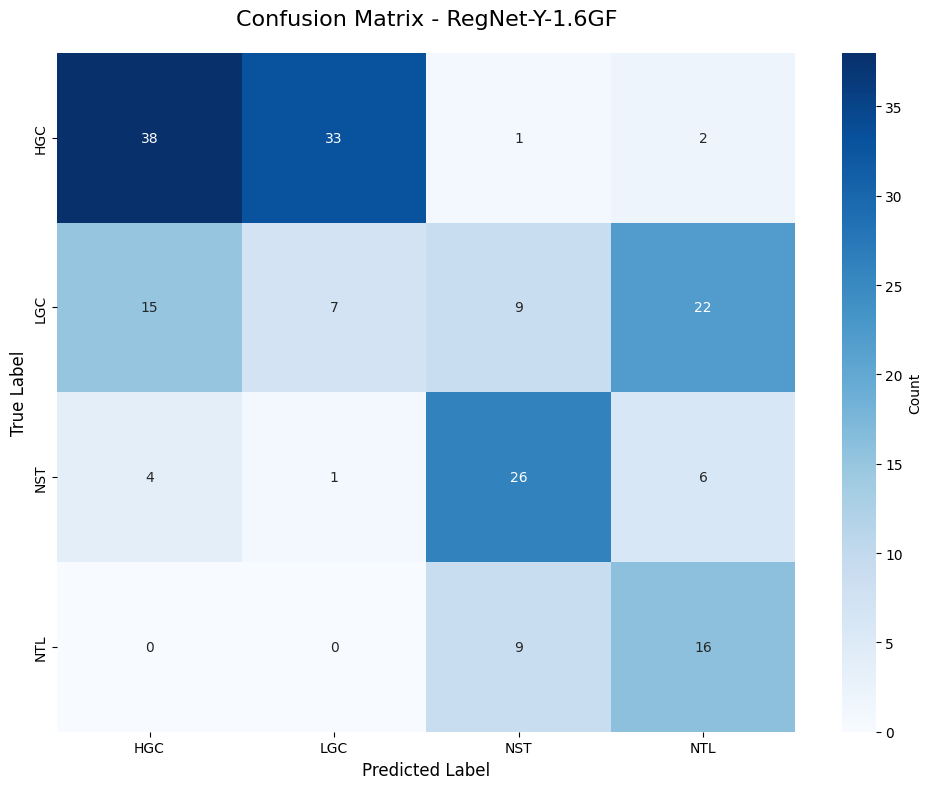

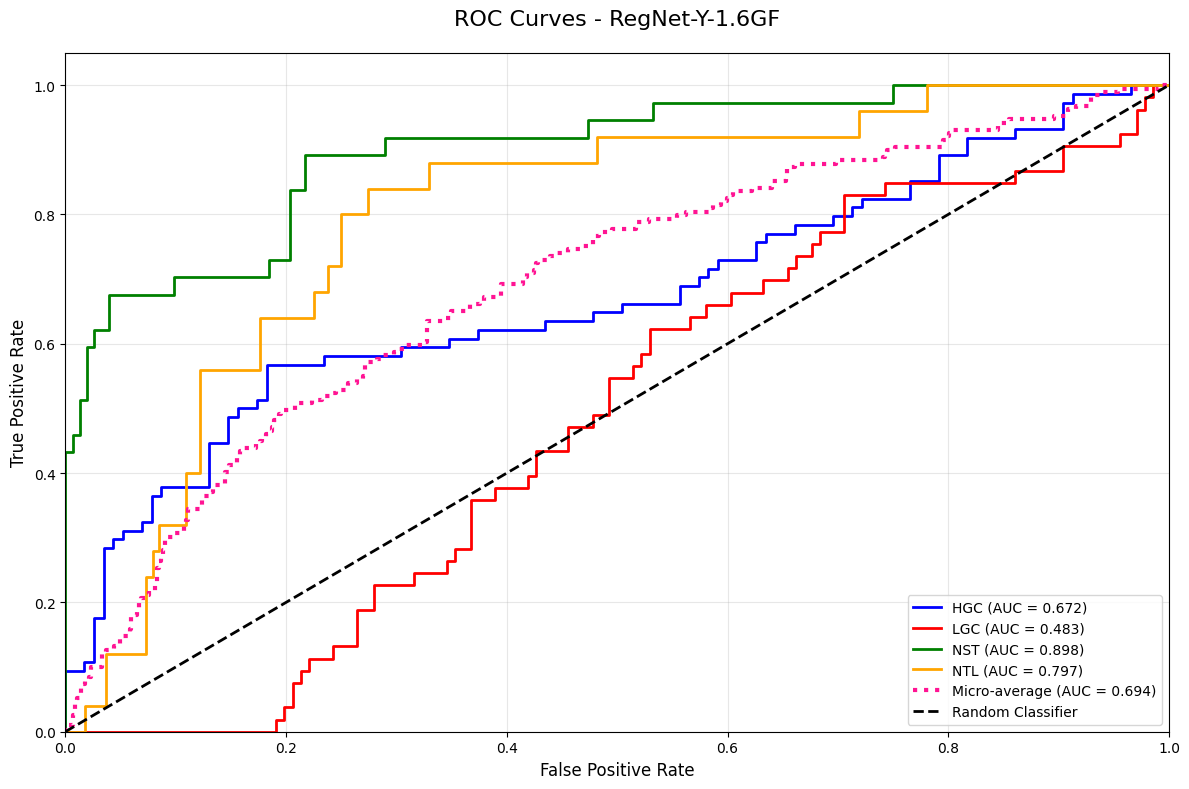


RegNet-Y-1.6GF training and evaluation complete!


In [18]:
print("=" * 80)
print("Training RegNet-Y-1.6GF with Imaging Type")
print("=" * 80)

# Create RegNet-Y-1.6GF model
regnet_1_6gf = create_regnet_y_1_6gf(
    num_classes=4,
    num_imaging_types=2,
    pretrained=True
)

# Create trainer
trainer_1_6gf = ModelTrainer(regnet_1_6gf, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_1_6gf = trainer_1_6gf.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="RegNet-Y-1.6GF_with_ImagingType")

# Plot training history
trainer_1_6gf.plot_training_history(save_path='regnet_y_1_6gf_training_history.png')

# Evaluate model
results_1_6gf = trainer_1_6gf.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_1_6gf['confusion_matrix'], class_names, 'RegNet-Y-1.6GF',
                      save_path='regnet_y_1_6gf_confusion_matrix.png')
# Plot ROC curves
roc_auc_1_6gf = plot_roc_curves(results_1_6gf['labels'], results_1_6gf['probabilities'], class_names, 'RegNet-Y-1.6GF',
                              save_path='regnet_y_1_6gf_roc_curves.png')
# Store results
results_1_6gf['model_name'] = 'RegNet-Y-1.6GF_with_ImagingType'
results_1_6gf['roc_auc'] = roc_auc_1_6gf
all_results.append(results_1_6gf)

print("\nRegNet-Y-1.6GF training and evaluation complete!")

# Save All Metrics to CSV

In [19]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'RegNet_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())



Metrics saved to: RegNet_metrics.csv

Metrics Summary:
                             Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  RegNet-Y-400MF_with_ImagingType         44.444444      1.836010             0.493417          0.545105      0.437087                0.548751             0.444444         0.414176       0.720000    0.243243  0.363636         74.0       0.464286    0.245283  0.320988         53.0       0.507692    0.891892  0.647059         37.0       0.281690        0.80  0.416667         25.0   0.773135   0.705514  0.794477  0.617370 